# Numpyro Integration

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install git+https://github.com/thomaspinder/GPJax.git#egg=GPJax")

In [6]:
import gpjax
import numpyro
import jax
import jax.numpy as jnp
import jax.random as jr
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
from jax import grad, jit

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

tfd = tfp.distributions
key = jr.PRNGKey(123)
print(gpjax.__version__)
from pprint import pprint

%matplotlib inline
%load_ext autoreload
%load_ext lab_black
%autoreload 2

0.3.3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Data

In [7]:
N = 50
noise = 0.2

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

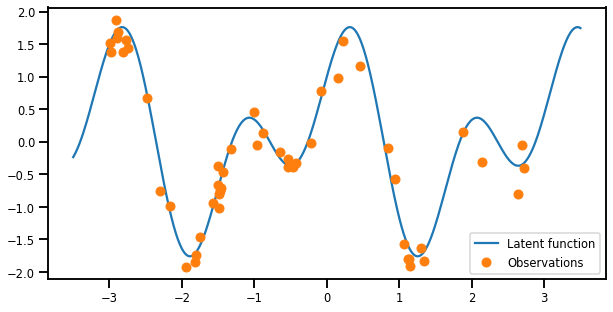

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.plot(x, y, "o", label="Observations", color="tab:orange")
ax.legend(loc="best")
plt.show()

## Gaussian Process Regression Model

In [9]:
from gpjax.gps import Prior
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian


kernel = RBF()
prior = Prior(kernel=kernel)

lik = Gaussian()
posterior = prior * lik

### Initialize Parameters

In [10]:
from gpjax.parameters import initialise

params = initialise(posterior)

print(params)

{'lengthscale': DeviceArray([1.], dtype=float64), 'obs_noise': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}


### Numpyro Style Parameters

In [11]:
from gpjax.interfaces.numpyro import add_constraints, numpyro_dict_params

In [12]:
numpyro_params = numpyro_dict_params(params)
pprint(numpyro_params)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f8802e9f250>,
                 'init_value': DeviceArray([1.], dtype=float64),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f8802e9f250>,
               'init_value': DeviceArray([1.], dtype=float64),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f8802e9f250>,
              'init_value': DeviceArray([1.], dtype=float64),
              'param_type': 'param'}}


### Adding Constraints

We can modify the parameters such that there are constraints.

#### Example I - All Positive

In [13]:
from numpyro.distributions import constraints

# example 1 - adding positive for everything
numpyro_params_ = add_constraints(numpyro_params, constraints.real)
numpyro_params_

{'lengthscale': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7f8802e9f370>},
 'obs_noise': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7f8802e9f370>},
 'variance': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7f8802e9f370>}}

#### Example II - A specific Variable Real

In [14]:
# example 1 - adding positive for everything
numpyro_params_ = add_constraints(numpyro_params, "lengthscale", constraints.positive)
numpyro_params_

{'lengthscale': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7f8802e9f250>},
 'obs_noise': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7f87e40636d0>},
 'variance': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7f87e40636d0>}}

#### Example III - 1 interval, 1 greater than 

In [15]:
# example 1 - adding positive for everything
new_constraints = {
    "lengthscale": constraints.greater_than(0.01),
    "obs_noise": constraints.interval(0.1, 0.001),
}

numpyro_params_ = add_constraints(numpyro_params, new_constraints)
# pprint(numpyro_params)
pprint(numpyro_params_)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f880ae5a970>,
                 'init_value': array([1.]),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._Interval object at 0x7f880ae5a9d0>,
               'init_value': array([1.]),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f880ae5ab50>,
              'init_value': array([1.]),
              'param_type': 'param'}}


## Maximum Likelihood Estimation

### Model

In [16]:
from numpyro.infer.autoguide import AutoDelta
from gpjax.interfaces.numpyro import numpyro_marginal_ll

# initialize parameters
params = initialise(posterior)
# convert to numpyro-style params
numpyro_params = numpyro_dict_params(params)

# initialize numpyro-style GP model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

# approximate posterior
guide = lambda x, y: None

# Delta Guide
guide = AutoDelta(npy_model)

In [17]:
x.shape, y.T.shape

((50, 1), (1, 50))

In [18]:
with numpyro.handlers.seed(rng_seed=123):
    t = npy_model(x, y.T)
    assert t.shape[0] == x.shape[0]
    t = numpyro.handlers.trace(npy_model).get_trace(x, y.T)

list(t.keys())

['lengthscale', 'obs_noise', 'variance', 'y']

### Optimization

In [19]:
%%time
from numpyro.infer import SVI, Trace_ELBO

# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 2_500


# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), n_iterations, x, y.T)

100%|██████████| 2500/2500 [00:05<00:00, 436.93it/s, init loss: 3273.3523, avg. loss [2376-2500]: 866.9415]


CPU times: user 18.2 s, sys: 1min 59s, total: 2min 17s
Wall time: 7.26 s


### Plotting the Loss

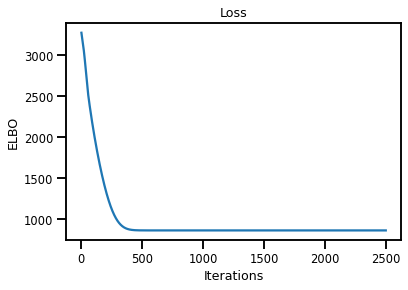

In [20]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="ELBO")
plt.show()

### Extracting the Parameters

In [21]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale': DeviceArray([0.4268455], dtype=float64),
 'obs_noise': DeviceArray([0.03674606], dtype=float64),
 'variance': DeviceArray([1.23430812], dtype=float64)}


### Predictions

In [22]:
from gpjax import mean, variance

predictive_mean = mean(posterior, learned_params, xtest, x, y).squeeze()
predictive_covariance = variance(posterior, learned_params, xtest, x, y).squeeze()

mu = predictive_mean
one_stddev = 1.96 * jnp.sqrt(jnp.diag(predictive_covariance))

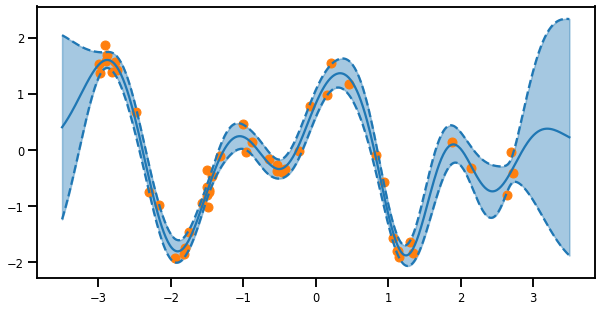

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

## Maximum A Posteriori

### Prior Parameters

In [24]:
import numpyro.distributions as dist

hyperpriors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.HalfCauchy(scale=1.0),
    "obs_noise": dist.HalfCauchy(scale=5.0),
}

#### Example I - Add a Prior

In [25]:
from gpjax.interfaces.numpyro import add_priors

numpyro_params = numpyro_dict_params(params)
numpyro_params_ = add_priors(numpyro_params, "lengthscale", dist.Gamma(1.0, 1.0))
pprint(numpyro_params_)

{'lengthscale': {'param_type': 'prior',
                 'prior': <numpyro.distributions.continuous.Gamma object at 0x7f880adafd90>},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f87dc2edd60>,
               'init_value': array([1.]),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f87dc2edd60>,
              'init_value': array([1.]),
              'param_type': 'param'}}


#### Example II - Add Multiple Priors

In [26]:
from gpjax.interfaces.numpyro import add_priors

numpyro_params = numpyro_dict_params(params)
pprint(numpyro_params)
numpyro_params = add_priors(numpyro_params, hyperpriors)
pprint(numpyro_params)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f8802e9f250>,
                 'init_value': DeviceArray([1.], dtype=float64),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f8802e9f250>,
               'init_value': DeviceArray([1.], dtype=float64),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7f8802e9f250>,
              'init_value': DeviceArray([1.], dtype=float64),
              'param_type': 'param'}}
{'lengthscale': {'param_type': 'prior',
                 'prior': <numpyro.distributions.continuous.Gamma object at 0x7f87dc2e9f40>},
 'obs_noise': {'param_type': 'prior',
               'prior': <numpyro.distributions.continuous.HalfCauchy object at 0x7f87dc2e9be0>},
 'variance': {'param_type': 'prior',
              'prior': <numpyro.distributions.continuous.HalfCauchy objec

### GP Model

In [27]:
# initialize mle model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

# Delta Guide
guide = AutoDelta(npy_model)

In [28]:
with numpyro.handlers.seed(rng_seed=123):
    t = npy_model(x, y.T)

### Optimization

In [29]:
%%time
from numpyro.infer import SVI, Trace_ELBO


# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 1_000

# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(rng_key, n_iterations, x, y)

100%|██████████| 1000/1000 [00:03<00:00, 313.03it/s, init loss: 222957.9621, avg. loss [951-1000]: 43350.9424]


CPU times: user 11.2 s, sys: 57.8 s, total: 1min 8s
Wall time: 6.07 s


### Losses

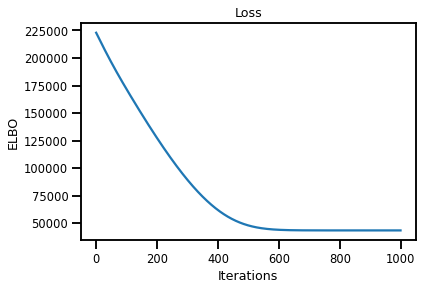

In [30]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="ELBO")
plt.show()

### Extracting the Parameters

In [31]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale_auto_loc': DeviceArray(0.42683607, dtype=float64),
 'obs_noise_auto_loc': DeviceArray(0.0367517, dtype=float64),
 'variance_auto_loc': DeviceArray(1.23414873, dtype=float64)}


We can also take the median which will eliminate the need for the `auto_loc` names.

In [32]:
median_params = guide.median(learned_params)
pprint(median_params)

{'lengthscale': DeviceArray(0.42683607, dtype=float64),
 'obs_noise': DeviceArray(0.0367517, dtype=float64),
 'variance': DeviceArray(1.23414873, dtype=float64)}


### Predictions

In [33]:
from gpjax import mean, variance

predictive_mean = mean(posterior, median_params, xtest, x, y).squeeze()
predictive_covariance = variance(posterior, median_params, xtest, x, y).squeeze()

mu = predictive_mean
one_stddev = 1.96 * jnp.sqrt(jnp.diag(predictive_covariance))

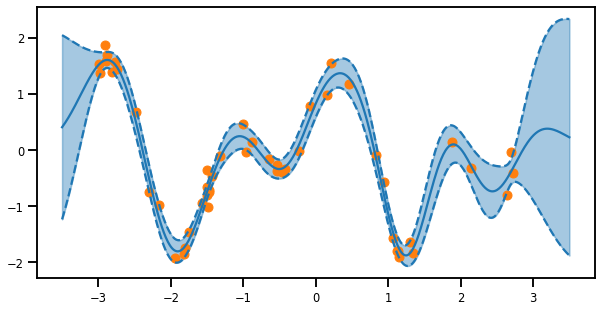

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

## Hamiltonian Monte Carlo

### Model

In [35]:
# initialize mle model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

### Sampling

Since we are doing sampling, there is no need to define a variational distribution.

In [36]:
from numpyro.infer import MCMC, NUTS


# reproducibility
rng_key = jax.random.PRNGKey(0)

# NUTS Parameters
n_samples = 1_000
n_warmup = 100
# Setup
kernel = NUTS(npy_model)

nuts_sampling = MCMC(kernel, num_samples=n_samples, num_warmup=n_warmup)
nuts_sampling.run(rng_key, x, y)

sample: 100%|██████████| 1100/1100 [00:21<00:00, 50.49it/s, 7 steps of size 3.09e-03. acc. prob=0.87]  


In [37]:
nuts_sampling.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.43      0.00      0.43      0.42      0.43    251.49      1.00
    obs_noise      0.04      0.00      0.04      0.04      0.04   1368.51      1.00
     variance      1.24      0.01      1.24      1.21      1.25     95.68      1.00

Number of divergences: 0


### Posterior Samples

In [38]:
posterior_params_samples = nuts_sampling.get_samples()

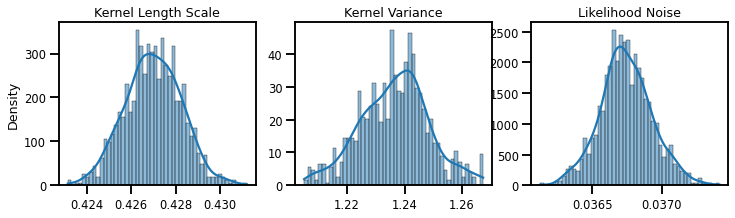

In [39]:
# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(
    ax=ax[0],
    x=posterior_params_samples["lengthscale"],
    kde=True,
    bins=50,
    stat="density",
)
sns.histplot(
    ax=ax[1], x=posterior_params_samples["variance"], kde=True, bins=50, stat="density"
)
sns.histplot(
    ax=ax[2], x=posterior_params_samples["obs_noise"], kde=True, bins=50, stat="density"
)

ax[0].set(title="Kernel Length Scale")
ax[1].set(title="Kernel Variance", ylabel="")
ax[2].set(title="Likelihood Noise", ylabel="")

plt.show()

### Median Parameters

In [40]:
def get_median_parameters(samples: dict) -> dict:
    median_params = {}
    for ikey, iarray in samples.items():
        median_params[ikey] = jnp.median(iarray)
    return median_params

In [41]:
median_params = get_median_parameters(posterior_params_samples)
pprint(median_params)

{'lengthscale': DeviceArray(0.42698255, dtype=float64),
 'obs_noise': Buffer(0.03673341, dtype=float64),
 'variance': Buffer(1.23698105, dtype=float64)}


### Predictions

In [42]:
from gpjax import mean, variance

predictive_mean = mean(posterior, median_params, xtest, x, y).squeeze()
predictive_covariance = variance(posterior, median_params, xtest, x, y).squeeze()

mu = predictive_mean
one_stddev = 1.96 * jnp.sqrt(jnp.diag(predictive_covariance))

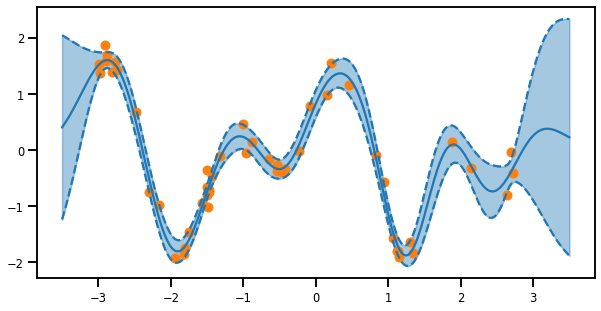

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

### All Posteriors

In [44]:
from gpjax import random_variable


def sample_posterior_from_params(
    rng, params, posterior, xtest, x, y, jitter_amount=1e-6, n_samples=1
):
    # create a random variable given parameters
    predictive_rv = random_variable(
        posterior, params, xtest, x, y, jitter_amount=jitter_amount
    )
    # sample from the rv
    return predictive_rv.sample(sample_shape=(n_samples,), seed=rng).squeeze()


# make the sampling faster
sample_posterior = jax.jit(
    jax.partial(
        sample_posterior_from_params,
        posterior=posterior,
        xtest=xtest,
        x=x,
        y=y,
        jitter_amount=1e-6,
        n_samples=1,
    )
)

In [46]:
# sample from the posterior
n_samples = 1_000
seed = 123

mcmc_posterior_samples = jax.vmap(sample_posterior, in_axes=(0, 0))(
    jax.random.split(jax.random.PRNGKey(seed), n_samples), posterior_params_samples
)
mcmc_posterior_samples.shape

(1000, 500)

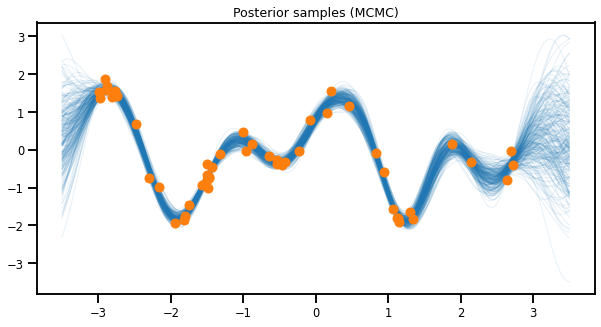

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(xtest, mcmc_posterior_samples[:250].T, color="tab:blue", alpha=0.1, lw=1)
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.set_title("Posterior samples (MCMC)")
plt.show()